# Education ...

Project descriptions

## Step 1: Loading and exploring the dataset

In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
# read in the mathematics dataset
port_df = pd.read_csv("student-por.csv", sep=";")


## Step 2: Pre-processing

In [2]:
# Check for missing values
print(port_df.isnull().values.any())

False


G3 (final year grade) was calculated using G1 and G2 (1st and 2nd period grades). We will use G3 as the responce variable and later on as the class variable by converitng it to a discrete scale. Since G3 is correlated with G1 and G2, the period grade variables will not be used as predictors in this analysis.

About categorical/numeric...

In [5]:
# Remove G1 and G2 
df = port_df.drop(['G1', 'G2'], axis = 1)

#df.info()
#<-------------------- Convert grade to a discrete scale ---------------------->#
# Conversion intervals based on Portugal's grade classification system

'''
conditions = [
    (df['G3'] >= 0) & (df['G3'] < 7),
    (df['G3'] >= 7) & (df['G3'] < 10),
    (df['G3'] >= 10) & (df['G3'] < 14),
    (df['G3'] >= 14) & (df['G3'] < 16),
    (df['G3'] >= 16) & (df['G3'] < 18),
    (df['G3'] >= 18) & (df['G3'] <= 20)
]
choices = ['very poor', 'poor', 'sufficient', 'good', 'very good', 'excellent']
'''

# a less fragmented classification with groups lumped together

conditions = [
    (df['G3'] >= 0) & (df['G3'] < 10),
    (df['G3'] >= 10) & (df['G3'] < 16),
    (df['G3'] >= 16) & (df['G3'] <= 20)
]

choices = ['very poor to poor', 'sufficient to good', 'very good to excellent']


# corresponding grade classifications

df['G3_discrete'] = np.select(conditions, choices)

conditions_binary = [
    (df['G3'] >= 0) & (df['G3'] < 10),
    (df['G3'] >= 10) & (df['G3'] <= 20)
]

choices_binary = ['fail', 'pass']
df['G3_binary'] = np.select(conditions_binary, choices_binary)


processed_df = df

# No longer need numeric grade column
#df = df.drop('G3', axis=1)

#<-------------------- Treat ordinal attributes as categorical, not numeric ---------------------->#

# Get column names
attributes = list(df)
# Exclude the attributes that should be treated as numeric
attributes = [a for a in attributes if a not in ('age', 'absences', 'G3')]
for attribute in attributes:
    df[attribute] = df[attribute].astype('category',copy=False)


#<-------------------- Change labels to numeric values ------------------------------------------->#

# Some categorical variables are already encoded with numbers (e.g. studytime 0-4), we need to encode the rest
# df.info()
#attributes = list(df)
#labels = [a for a in attributes if a not in ('age', 'absences', 'G3')]
labels = df.select_dtypes(include=['category'])

# object-type attributes are strings - we need to recode these
#labels = df.select_dtypes(include = "object").columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for l in labels:
    df[l] = le.fit_transform(df[l].astype(str))
#print(df.head())




In [6]:

#<-------------------- Treat ordinal attributes as categorical, not numeric ---------------------->#

# Get column names
def category_converter(df):
    attributes = list(df)
    # Exclude the attributes that should be treated as numeric
    attributes = [a for a in attributes if a not in ('age', 'absences', 'G3')]
    for attribute in attributes:
        df[attribute] = df[attribute].astype('category',copy=False)
    return df


#<-------------------- Change labels to numeric values ------------------------------------------->#

# Some categorical variables are already encoded with numbers (e.g. studytime 0-4), we need to encode the rest
# df.info()
#attributes = list(df)
#labels = [a for a in attributes if a not in ('age', 'absences', 'G3')]

def label_encoder(df):
    labels = df.select_dtypes(include=['category'])

    # object-type attributes are strings - we need to recode these
    #labels = df.select_dtypes(include = "object").columns
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for l in labels:
        df[l] = le.fit_transform(df[l].astype(str))
    return df
    #print(df.head())
    
#<-------------------- One hot encoder ------------------------------------------->#


def one_hot_encoder(df):
    labels = df.select_dtypes(include=['category'])

    # object-type attributes are strings - we need to recode these
    #labels = df.select_dtypes(include = "object").columns
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for l in labels:
        df[l] = le.fit_transform(df[l].astype(str))
    return df
    #print(df.head())


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


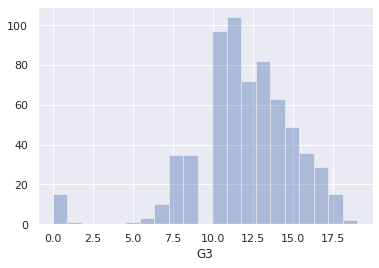

In [7]:
# check if G3 values make sense (are between 0 and 20)
import seaborn as sn
sn.set(color_codes=True)
sn.distplot(df['G3'], kde=False)

# As expected, the grade distribution is approximately bell-curved. 
# The class "sufficient to good" clearly dominates the dataset

# Need to use under-sampling



In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

class_1 = df[df['G3_discrete'] == 1 ] 
class_0 = df[df['G3_discrete'] == 0 ].sample(len(class_1), random_state = 0)
class_2 = df[df['G3_discrete'] == 2 ].sample(len(class_1), random_state = 0) 
frames = [class_1, class_2, class_0]
balanced_sample = pd.concat(frames)

#<-------------------- Correlation-Based Feature Selection -------------------------------------->
X_cfs = balanced_sample.drop(['G3_discrete','G3_binary', 'G3'], axis=1)
y = balanced_sample['G3_discrete']

from skfeature.function.statistical_based import CFS
idx = CFS.cfs(X_cfs.values, y)
#df_cfs = balanced_sample.columns[idx]
df_cfs = balanced_sample.iloc[:, idx]

#<-------------------- Feature Selection (Chi-squared) -------------------------------------->
X = balanced_sample.drop(['G3_discrete','G3_binary', 'G3'], axis=1)
y = balanced_sample['G3_discrete']
selector = SelectKBest(chi2, k=14)
feature_data = selector.fit_transform(X, y)
mask=selector.get_support()
feature_names = X.columns[mask]
df_selected = pd.DataFrame(feature_data, columns=feature_names)

# full dataset with feature selection
df_selected_full = pd.DataFrame(feature_data, columns=feature_names)

# Now split the data into training and testing (80/20)
train_x, test_x, train_y, test_y = train_test_split(df_selected, y, stratify=y, test_size=0.2, random_state=42)
# no feature selection
# train_x, test_x, train_y, test_y = train_test_split(df.drop(['G3_discrete','G3_binary', 'G3', 'school'], axis=1), df['G3_discrete'],stratify=df['G3_discrete'], test_size=0.2, random_state=42)
#g_class = GaussianNB()

#Train the model using the training sets
#g_class.fit(train_x, train_y)

#Predict the response for test dataset
#pred_y = g_class.predict(test_x)

#cm=metrics.confusion_matrix(test_y,pred_y)
#df_cm = pd.DataFrame(cm, range(6), range(6))

#sn.set(font_scale=1.4) # for label size
#sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

#plt.show()

#np.count_nonzero(pred_y!=test_y)

#sum(train_y==2)

[2 5 5 5 4 4 4 4 2 2 5 5 5]
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        16
           1       0.77      0.59      0.67        17
           2       0.67      0.82      0.74        17

   micro avg       0.70      0.70      0.70        50
   macro avg       0.71      0.70      0.70        50
weighted avg       0.71      0.70      0.70        50

0.7


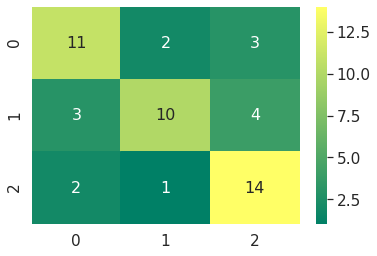

In [20]:
# already installed the package with pip install mixed-naive-bayes
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mixed_naive_bayes import MixedNB

indices=[]
attributes = list(train_x)
attributes = [a for a in attributes if a not in ('age', 'absences')]
#print(attributes)
#print(train_x)
for attr in attributes:
    indices.append(train_x.columns.get_loc(attr))

clf = MixedNB(categorical_features=indices)

clf.fit(train_x,train_y)
pred = clf.predict(test_x)

cm=confusion_matrix(test_y,pred)
df_cm = pd.DataFrame(cm, range(3), range(3))

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="summer") # font size


# calculate accuracy of the model
sum(pred==test_y)/len(test_y)

#best
#l=['class 0', 'class 1', 'class 2']
print(classification_report(test_y, pred))

print(sum(pred==test_y)/len(test_y))


In [825]:
# selected features
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 14 columns):
school        246 non-null int64
Medu          246 non-null int64
Fedu          246 non-null int64
Mjob          246 non-null int64
reason        246 non-null int64
traveltime    246 non-null int64
studytime     246 non-null int64
failures      246 non-null int64
schoolsup     246 non-null int64
higher        246 non-null int64
freetime      246 non-null int64
Dalc          246 non-null int64
Walc          246 non-null int64
absences      246 non-null int64
dtypes: int64(14)
memory usage: 27.0 KB
None


In [848]:
from skfeature.function.statistical_based import CFS
idx = CFS.cfs(X.values, y)


array([14, 20,  0,  7, 25,  6, 10, 23, 13])

In [833]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
'''
test_joint = pd.DataFrame(test_x, test_y, pred)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_y[test_y==i], pred[test_y==i])
    roc_auc[i] = auc(fpr[i], tpr[i])
'''



'\ntest_joint = pd.DataFrame(test_x, test_y, pred)\nfpr = dict()\ntpr = dict()\nroc_auc = dict()\nfor i in range(3):\n    fpr[i], tpr[i], _ = roc_curve(test_y[test_y==i], pred[test_y==i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 8 to 393
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   failures   246 non-null    int64
 1   higher     246 non-null    int64
 2   school     246 non-null    int64
 3   Fedu       246 non-null    int64
 4   goout      246 non-null    int64
 5   Medu       246 non-null    int64
 6   reason     246 non-null    int64
 7   famrel     246 non-null    int64
 8   studytime  246 non-null    int64
dtypes: int64(9)
memory usage: 19.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      246 non-null    int64
 1   Medu        246 non-null    int64
 2   Fedu        246 non-null    int64
 3   Mjob        246 non-null    int64
 4   reason      246 non-null    int64
 5   traveltime  246 non-null    int64
 6   studytime   

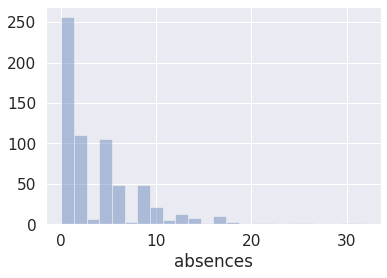

In [23]:
# Comments on NB assumptions
#sn.distplot(df['age'], kde=False)
print(df_cfs.info())
print(df_selected.info())

sn.distplot(df['absences'], kde=False)

## Random forest

In [921]:
from sklearn.ensemble import RandomForestClassifier
# create model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# train the model
rf.fit(train_x, train_y);



In [926]:
#df['col_name'] = df['col_name'].astype('category')

predictions = rf.predict(test_x)
#print(sum(predictions==test_y)/len(test_y))
# Calculate the absolute errors
#errors = abs(predictions - test_y)
# Print out the mean absolute error (mae)
#print('Mean Absolute Error:', round(np.mean(errors), 2))
#predictions
#for p in predictions:
#    p = np.round(p)
    
#predictions = [np.round(p) for p in predictions]
print(sum(predictions==test_y)/len(test_y))
#predictions
'''
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# 
from sklearn.tree import export_graphviz

# sudo apt install python-pydot python-pydot-ng graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot',  rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('tree.png')
plt.imshow(img)
plt.show()
'''

0.0


"\n# Import tools needed for visualization\nfrom sklearn.tree import export_graphviz\nimport pydot\n# Pull out one tree from the forest\ntree = rf.estimators_[5]\n# \nfrom sklearn.tree import export_graphviz\n\n# sudo apt install python-pydot python-pydot-ng graphviz\nimport pydot\n# Pull out one tree from the forest\ntree = rf.estimators_[5]\n# Export the image to a dot file\nexport_graphviz(tree, out_file = 'tree.dot',  rounded = True, precision = 1)\n# Use dot file to create a graph\n(graph, ) = pydot.graph_from_dot_file('tree.dot')\n# Write graph to a png file\ngraph.write_png('tree.png')\n\nimport matplotlib.pyplot as plt\nimport matplotlib.image as mpimg\n\nimg = mpimg.imread('tree.png')\nplt.imshow(img)\nplt.show()\n"

In [105]:
# recode into binary
rf_df = df_selected
y = balanced_sample['G3_discrete']

attributes = list(rf_df)
attributes = [a for a in attributes if a not in ('age', 'absences', 'G3_discrete')]
#labels = rf_df.select_dtypes(include=['category'])
#attributes
#ohe = OneHotEncoder()
#for l in labels:
#    rf_df[l] = ohe.fit_transform(rf_df[l].astype(str))
#rf_df 
#rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

#rf_df = pd.get_dummies(rf_df, prefix=attributes, columns=attributes) 
#rf_df['G3_discrete'] = le.fit_transform(rf_df['G3_discrete'].astype(str))
#rf_class= pd.factorize(rf_df['G3_discrete'])
#print(rf_df)

#X = rf_df.drop(['G3_discrete', 'G3_binary'], axis=1)
#y = rf_df['G3_discrete']
#X = rf_df.drop(['G3_discrete'], axis=1)
#y = rf_df['G3_discrete']
train_x, test_x, train_y, test_y = train_test_split(rf_df, y, test_size=0.2, stratify = y, random_state=42)
#rf.fit(train_x, train_y);
#predictions = rf.predict(test_x)
#print(sum(predictions==test_y)/len(test_y))
# Calculate the absolute errors
#errors = abs(predictions - test_y)
# Print out the mean absolute error (mae)
#print('Mean Absolute Error:', round(np.mean(errors), 2))
#predictions
#for p in predictions:
#    p = np.round(p)
    
#predictions = [np.round(p) for p in predictions]
#
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:42: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [233]:
#from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Using information gain (entropy) to evaluate how good a particular split is
classifier = RandomForestClassifier(n_estimators = 1100, min_samples_leaf= 1,
 min_samples_split= 4, max_depth=3, random_state = 42)
classifier.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [234]:
#predictions

predictions = classifier.predict(test_x)

print(sum(predictions==test_y)/len(test_y))

0.68


              precision    recall  f1-score   support

           0       0.75      0.56      0.64        16
           1       0.86      0.71      0.77        17
           2       0.58      0.82      0.68        17

   micro avg       0.70      0.70      0.70        50
   macro avg       0.73      0.70      0.70        50
weighted avg       0.73      0.70      0.70        50



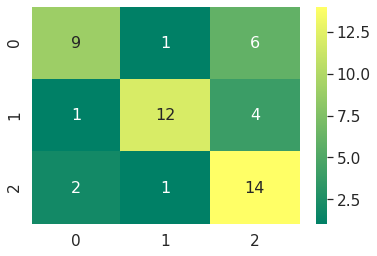

In [181]:
cm=confusion_matrix(test_y,predictions)
df_cm = pd.DataFrame(cm, range(3), range(3))

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="summer") # font size
print(classification_report(test_y, predictions))


In [1092]:
balanced_sample

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G3,G3_discrete,G3_binary


In [196]:
# Hyperparameter tuning with Random Hyperparameter Grid
from sklearn.model_selection import RandomizedSearchCV
criterion = ['entropy', 'gini']
# number of trees - 1000 seems to work well from just manual plugging in, anything below isn't good
n_estimators = [int(x) for x in np.linspace(start = 900, stop = 2000, num = 12)]
max_features = ['sqrt', 'log2', 'auto']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
#also evaluate having no limit on tree depth
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'criterion' : criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [194]:
print(random_grid)

{'n_estimators': [900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [200]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
cv = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = cv, param_distributions = random_grid, n_iter = 1000, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_x, train_y)

Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed: 41.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=2500, n_jobs=-1,
          param_distributions={'n_estimators': [900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          retur

In [201]:
base_model = RandomForestClassifier(n_estimators = 1000, random_state = 42)
base_model.fit(train_x, train_y)
predictions_base = base_model.predict(test_x)

best_model = rf_random.best_estimator_
predictions_best = best_model.predict(test_x)



print(sum(predictions_base==test_y)/len(test_y)) 
print(sum(predictions_best==test_y)/len(test_y)) 


0.62
0.64


In [204]:
rf_random.best_params_



{'n_estimators': 1300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'criterion': 'gini',
 'bootstrap': False}

In [222]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [1000, 1100, 1200, 1300],
    'min_samples_leaf': [1,2,3, 4],
    'min_samples_split': [2, 3, 4],
   # 'max_features': [2, 3],
    'max_depth': [2,3,4]
    #'bootstrap': [False],
    #'criterion': ['gini'] 
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(train_x, train_y)
grid_search.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.7min finished


{'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1100}